From [here](https://www.youtube.com/watch?v=vV12dGe_Fho) and [here](https://www.youtube.com/watch?v=z3ZnOW-S550) Rob Mulla

In [75]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TIme Series Forcasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

from sklearn.metrics import mean_squared_error 
#gives more penalty for predictions that are way off compared ot a little but off. Choose your metrics wisely.

import xgboost as xgb

In [77]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TIme Series Project/PJME_hourly.csv')
#

df['Datetime']= pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index(df['Datetime'])
df.index = df['Datetime']

In [78]:
df.dtypes

Datetime    datetime64[ns]
PJME_MW            float64
dtype: object

In [79]:
del df['Datetime']

<Axes: title={'center': 'PJME Energy Consumption'}, xlabel='Datetime'>

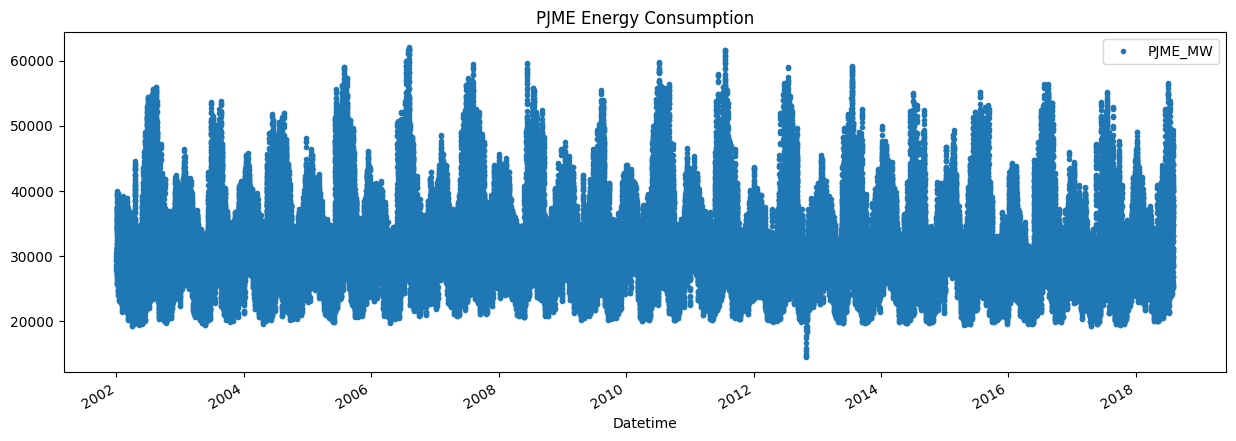

In [80]:
df.plot(style='.', figsize=(15,5), title='PJME Energy Consumption', color=color_pal[0])

# Train / Test Split

IF model goes production, then explore full cross validation in a time series dataset with fully productionised productions. Check out what they are. Split on january 2015. 

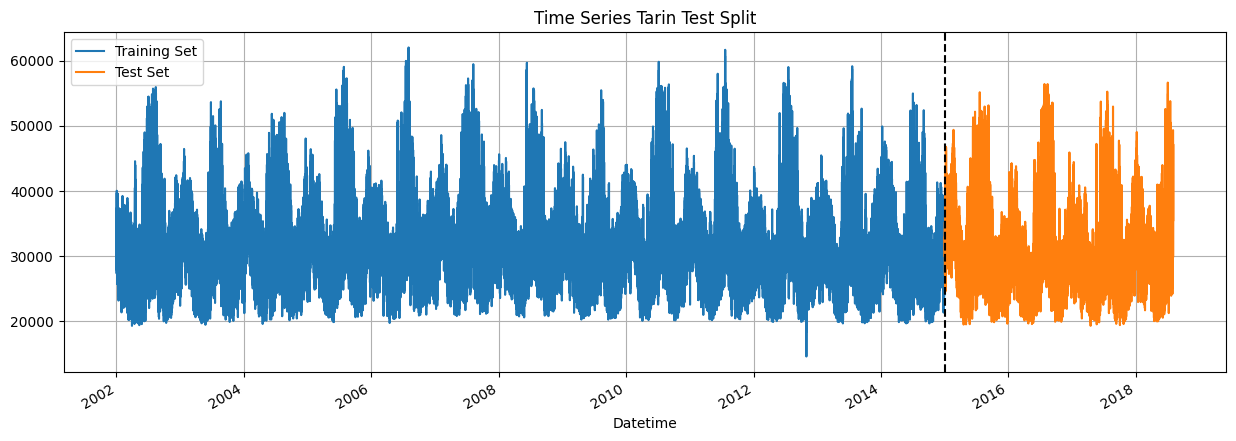

In [81]:
train = df.loc[df.index <'01-01-2015']
test = df.loc[df.index >='01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, color = color_pal[0], title = 'Time Series Tarin Test Split')
test.plot(ax=ax, color = color_pal[1])
ax.legend(['Training Set','Test Set'])
ax.axvline('01-01-2015', color = 'black', ls = '--')
plt.grid()

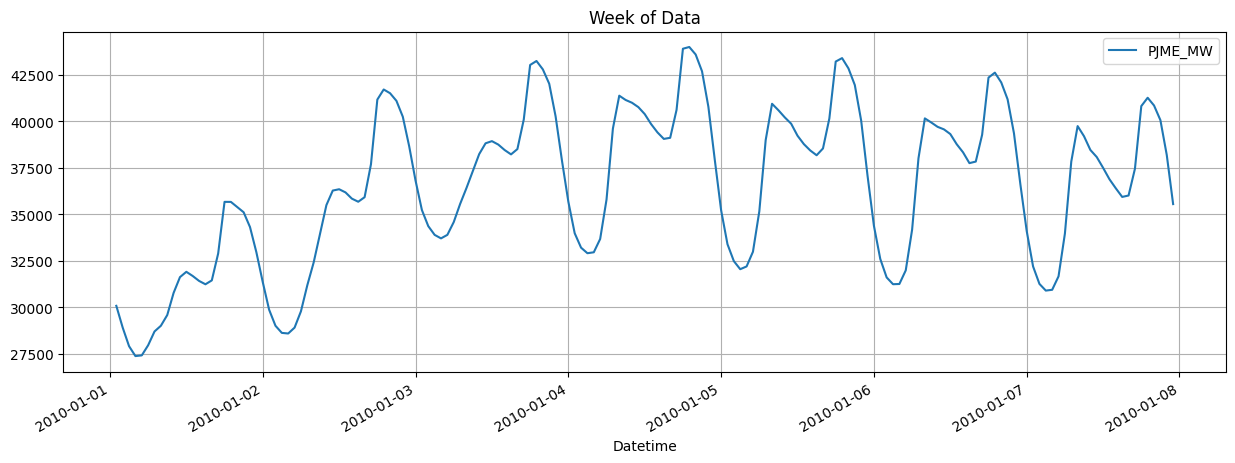

In [82]:
# one single week of Data
# notice the "\" being used here in case you want to spit the line in chain rule
# Notice the daily patterns and weekend patterns in the plot

df.loc[(df.index > '01-01-2010') & (df.index<'01-08-2010')] \
.plot(figsize = (15,5), title = "Week of Data")
plt.grid()

# Feature Creation

We create time Series features based on time series index, using a fucntion

In [83]:

def create_features(df):

  '''creating time series features
  '''
  
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter']= df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth']=df.index.day
  df['weekofyear']=df.index.isocalendar().week

  return df

df = create_features(df)

# Visualising the Feature/Target Relationship

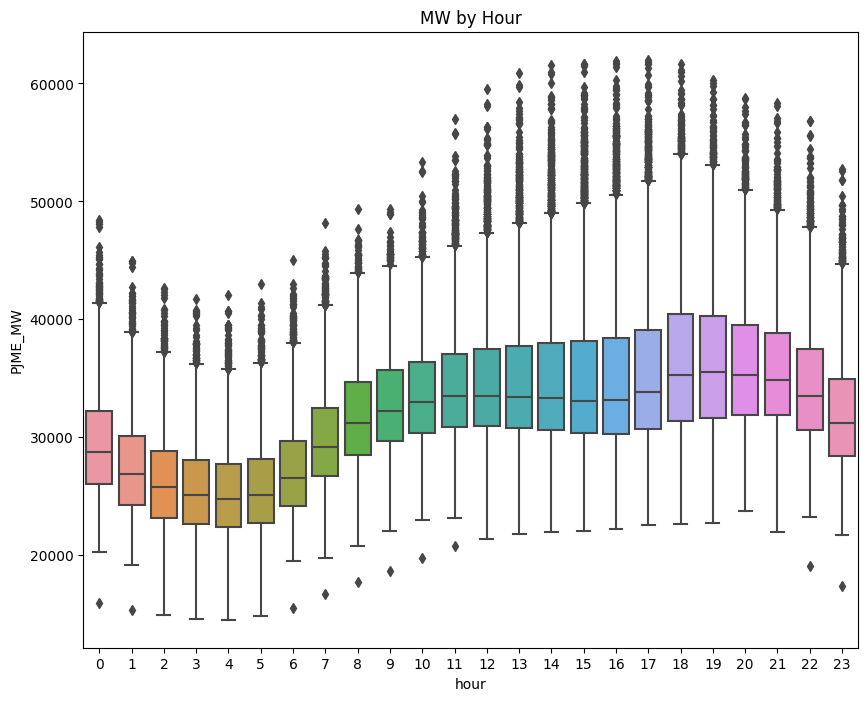

In [84]:
fig, ax = plt.subplots(figsize = (10,8))

sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

Notice the peak hours here, for the day

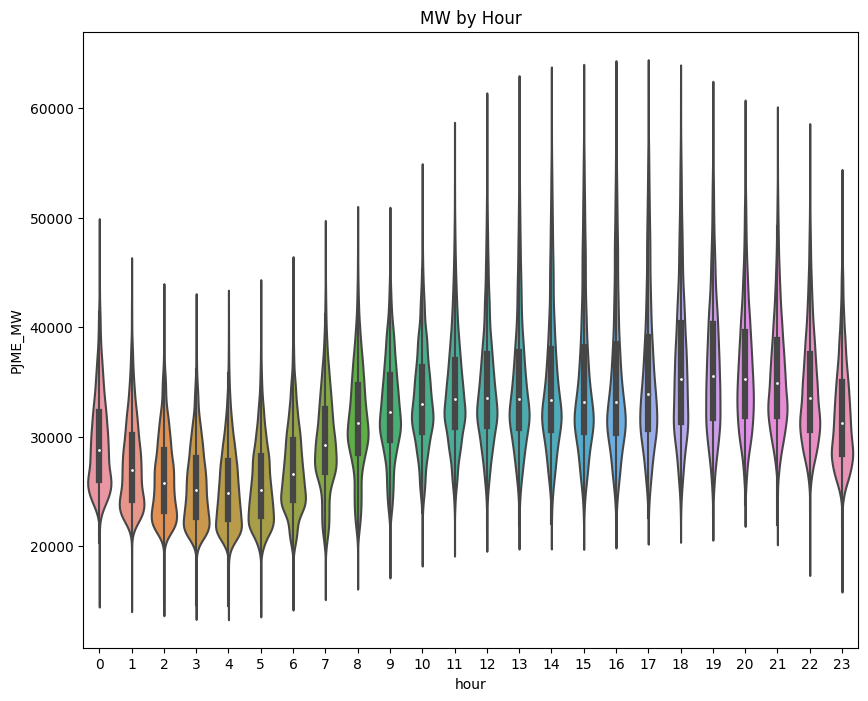

In [85]:
fig, ax = plt.subplots(figsize = (10,8))

sns.violinplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

Text(0.5, 1.0, 'MW by Month')

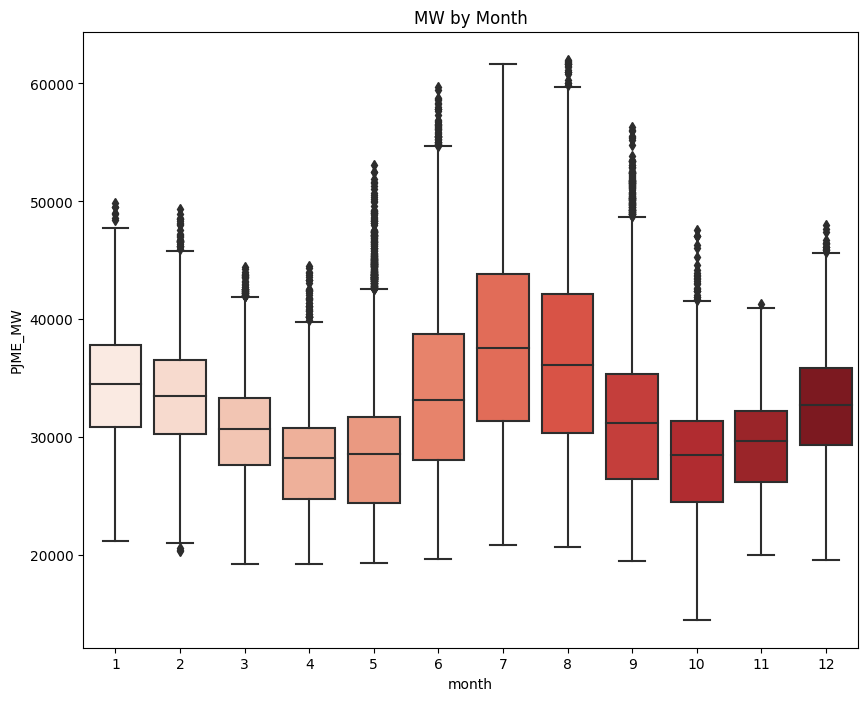

In [129]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(df, x= 'month', y = 'PJME_MW', palette = 'Reds')
ax.set_title ('MW by Month')

Notice the peak consumtion in the heightof summer as well as winter. 

# Create the Model

You can later add backtesting like Vik's model for preducting footbal matches, that is the robus Cross validation this dude was talking about too.

In [87]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour','dayofweek','quarter','month',
            'year','dayofmonth','dayofyear']

TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [88]:
# n_estimateros = is the number of trees created by the model.
# If you look at the view, he first ran the model without any learning rate or early stopping rounds
# and checked rmse for test and validation sets. rmse for validation comes own then goes up
# again as it starts overfitting, we can then use learning rate (lower it) and early stoppig time
# to find out the sweet spot

reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                       n_estimators = 1000,
                       early_stopping_rounds = 50,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train,y_train),(X_test, y_test)],
        verbose = 100)

[14:28:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.41930	validation_1-rmse:28762.55041
[100]	validation_0-rmse:3031.57895	validation_1-rmse:3741.92160
[176]	validation_0-rmse:2870.26298	validation_1-rmse:3758.45022


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

weekofyear had UInt32, XGBoost didnt like it.

# Feature Importance

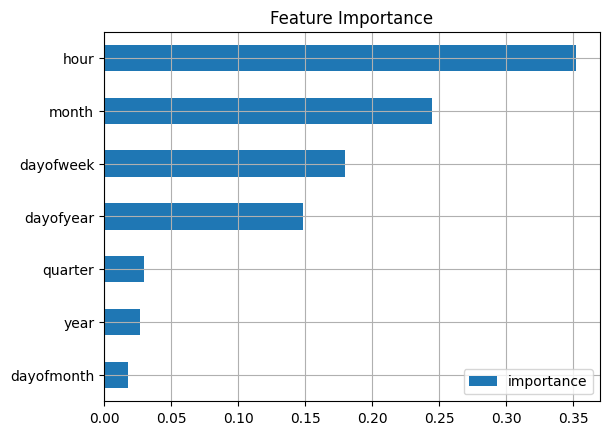

In [89]:
imp = pd.DataFrame(data = reg.feature_importances_,
                   index = reg.feature_names_in_,
                   columns = ['importance'])

imp.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.grid()
# Highly corrleated features will affect the usefullness of the feature importance

# Performing Forcasting on the Test Data

In [90]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index=True) 
# we merge these tow dataframes on the index columns, (essetially adding a column to the dataframe)

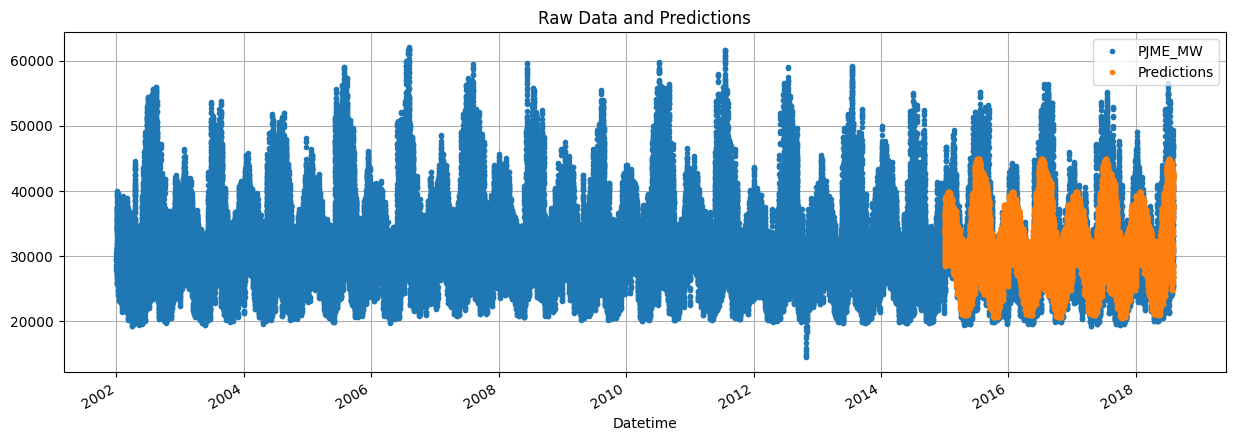

In [105]:
fig, ax = plt.subplots(figsize= (15,5))
df['PJME_MW'].plot(ax = ax, style = '.', title = 'Raw Data and Predictions', label = 'PJME_MW')
df['prediction'].plot(ax=ax, style = '.', label = 'Predictions')
ax.legend(loc = 'upper right')
plt.grid()

Looking at a week of Data

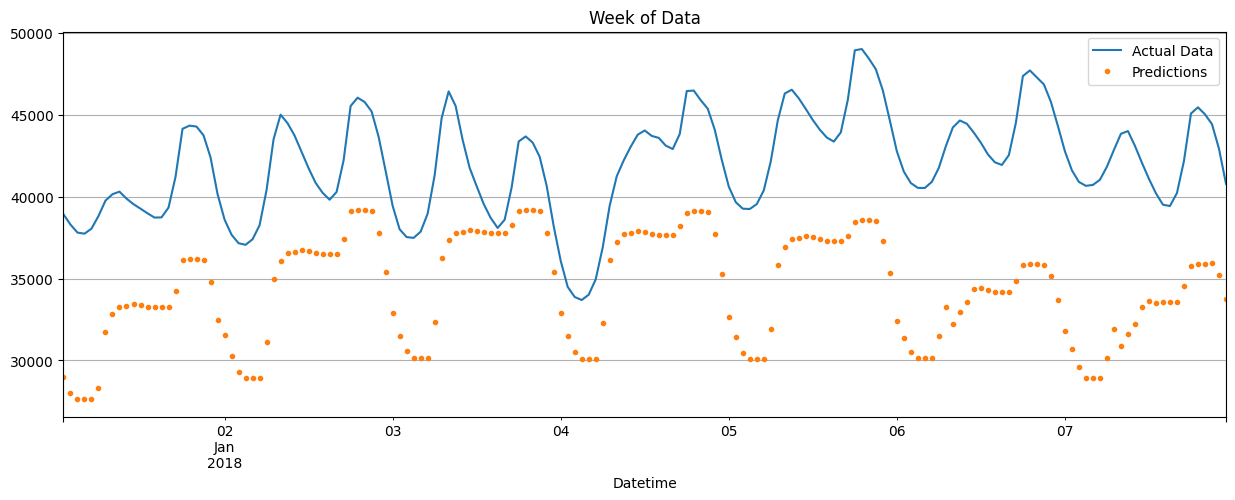

In [115]:
fig, ax = plt.subplots(figsize = (15,5))

df.loc[(df.index > '01-01-2018') & (df.index<'01-08-2018')]['PJME_MW'] \
.plot(ax = ax, title = "Week of Data", label = 'Actual Data')

df.loc[(df.index > '01-01-2018') & (df.index<'01-08-2018')]['prediction'] \
.plot(ax = ax, style = '.', label = 'Predictions')

ax.legend()
plt.grid()

# Score in the form of RMSE

In [118]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE score on the test set is: {score:0.2f}') # same metric as used above by xgboost.

RMSE score on the test set is: 3729.73


# Error Calculation
## Best and Worst Days in terms of prediction

In [119]:
test['error'] = np.abs(test[TARGET]-test['prediction']) #gets absolute value so negative and positive values dont matter.
test['date'] = test.index.date

In [126]:
test.groupby(['date'])['error'].mean().sort_values(ascending = False).head(10)

date
2016-08-13    13314.959310
2016-08-14    13265.499105
2016-09-10    11406.479167
2016-09-09    11235.600993
2015-02-20    10939.778890
2016-08-12    10470.473145
2018-01-06    10190.794759
2017-05-19     9836.352620
2015-02-16     9774.954508
2015-02-21     9730.991455
Name: error, dtype: float64

# Part 2:
## 1. Outlier analysis and removal

In [131]:
plt.style.use('fivethirtyeight')

<Axes: ylabel='Frequency'>

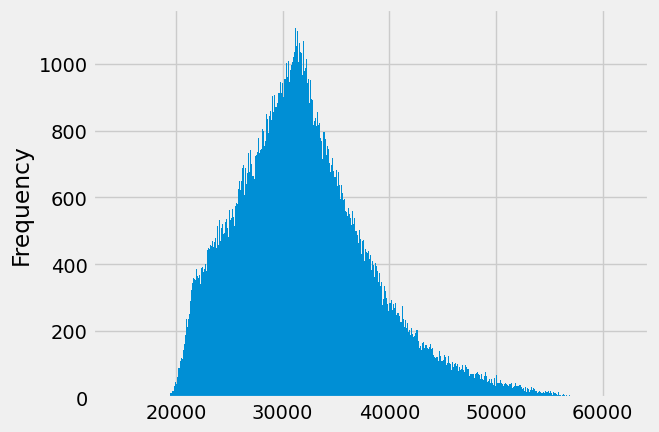

In [133]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)

<Axes: title={'center': 'Outlier'}, xlabel='Datetime'>

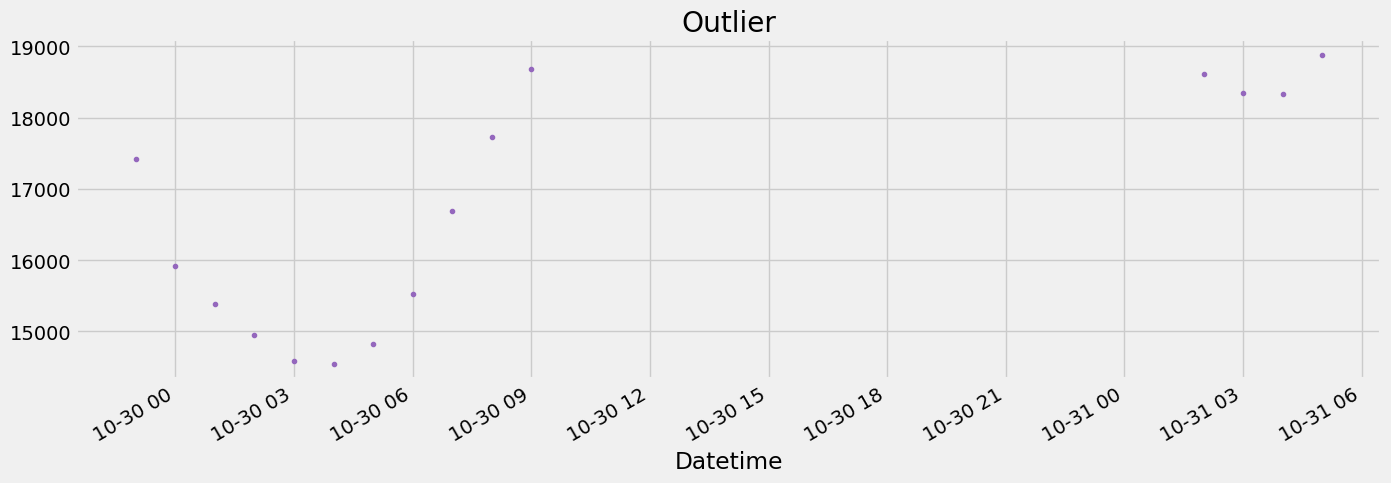

In [140]:
# Dropping values below 19000
df.query('PJME_MW <19000')['PJME_MW'] \
  .plot(style = '.',
        figsize = (15,5),
        color = color_pal[4],
        title = 'Outliers')

In [141]:
df = df.query('PJME_MW>19000').copy()

# Imporving the Time Series Cross Validation

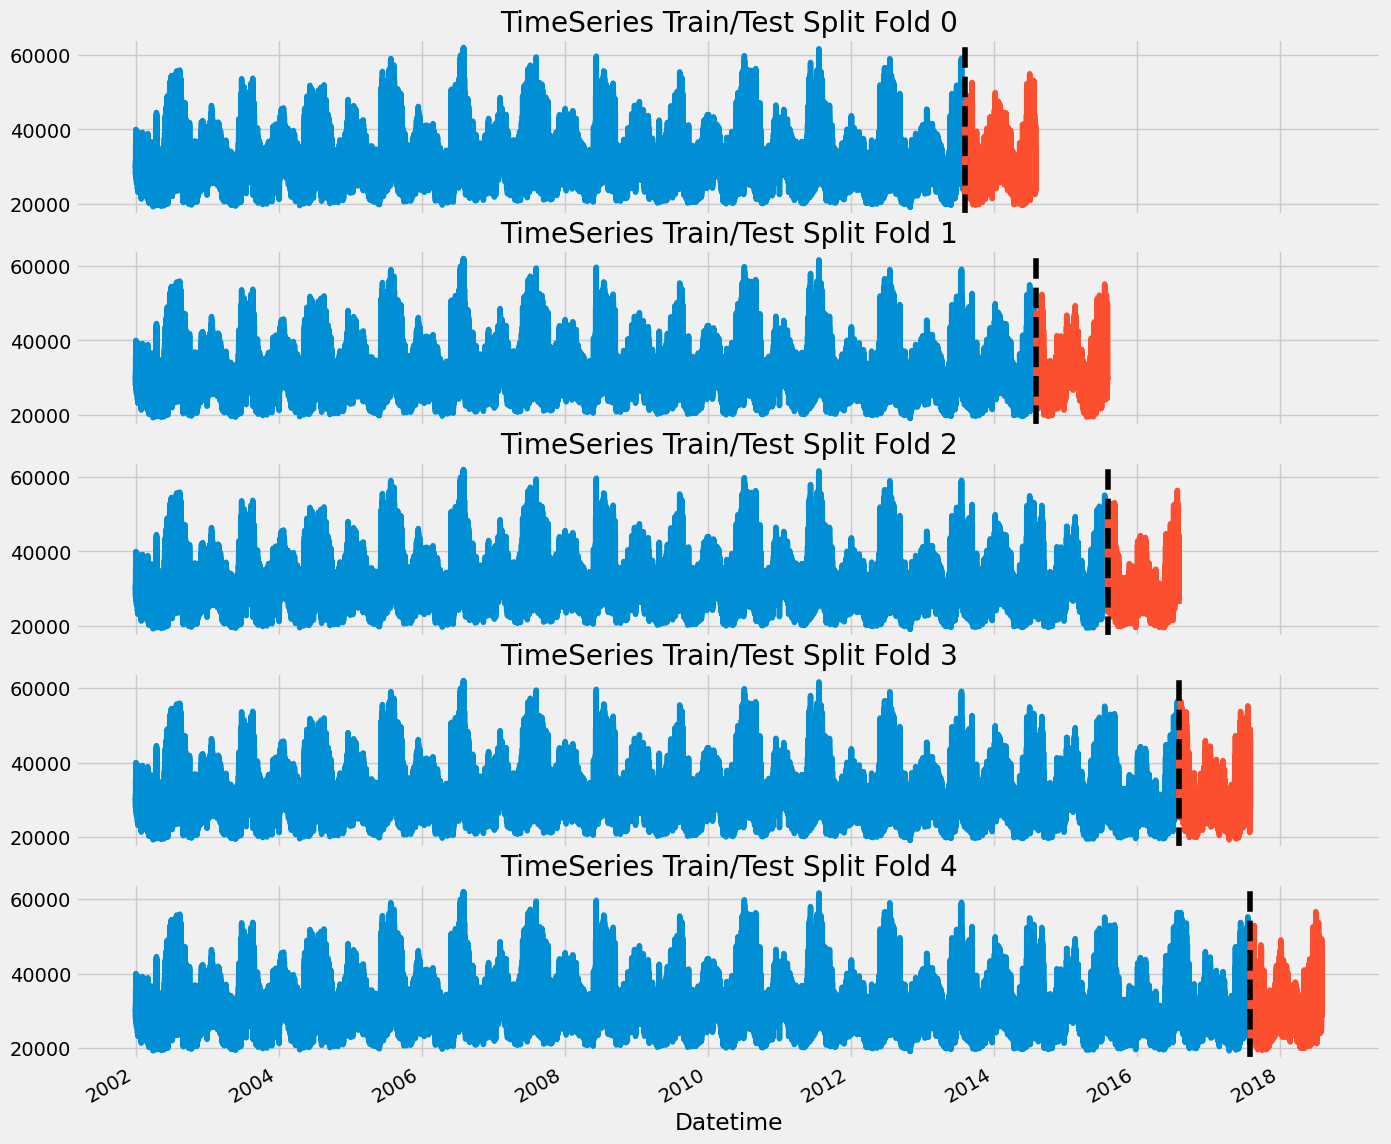

In [219]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24) 
df = df.sort_index()
# looks like the test size is all th ehour sin ayear with one day gap for each fold; Energy consuption is hourly
# This is a modification of kfold

fig, axs = plt.subplots(5, 1, figsize = (15, 15), sharex = True)
fold = 0

for train_idx, val_idx in tss.split(df): #validation index
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]

  train['PJME_MW'].plot(ax = axs[fold],
                        label = 'Training Set',
                        title = f'TimeSeries Train/Test Split Fold {fold}')
  
  test['PJME_MW'].plot(ax = axs[fold],
                       label = 'Test Set')
  
  axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
  fold +=1

plt.show()


# Forcasting Horizon
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years). Its is going to be harder to predict the mor eintot e future you go.
###You cannot add lag features further back than your time horizon. 

# Lag Features
- What was the target (n) days in the past, and use the target value for that date and feed it into the model. 

In [168]:
# Function adds 3 columns to the df, each with the consumtion values in the past 1, 2, 3 years 
# respectively.

def add_lags(df):
  target_map = df['PJME_MW'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
  return df

In [169]:
df = add_lags(df)

# Training Using TimeSeries Cross Validation

In [172]:
from xgboost.callback import EarlyStopping
from xgboost.sklearn import XGBRegressor
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24) 
df - df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]

  FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
              'lag1','lag2','lag3']
  TARGET = 'PJME_MW'


  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_test = test[FEATURES]
  y_test = test[TARGET]


  reg = XGBRegressor(base_score = 0.5, booster = 'gbtree',
                     n_estimators = 1000,
                     early_stopping_rounds = 50,
                     objective = 'reg:linear',
                     max_depth = 3,
                     learning_rate = 0.01)
  
  reg.fit(X_train, y_train,
          eval_set = [(X_train, y_train),(X_test, y_test)],
          verbose = 100)
  
  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

[16:27:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.30381	validation_1-rmse:31956.18912
[100]	validation_0-rmse:12532.08851	validation_1-rmse:11907.28743
[200]	validation_0-rmse:5743.63141	validation_1-rmse:5355.87526
[300]	validation_0-rmse:3866.68176	validation_1-rmse:3890.94882
[400]	validation_0-rmse:3429.68951	validation_1-rmse:3752.67972
[449]	validation_0-rmse:3356.69575	validation_1-rmse:3758.58399
[16:27:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76435	validation_1-rmse:32142.13257
[100]	validation_0-rmse:12513.14073	validation_1-rmse:12225.51268
[200]	validation_0-rmse:5755.09841	validation_1-rmse:5651.50008
[300]	validation_0-rmse:3906.44526	validation_1-rmse:3935.00246
[400]	validation_0-rmse:3477.03202	validation_1-rmse:3601.93393
[500]	validation_0-rmse:3355.81430	validation_1-rmse:3

In [178]:
print(f'Score across folds {np.mean(scores):0.6}')
print(f'Fold scores:{scores}')

Score across folds 3749.85
Fold scores:[3752.67972535384, 3439.9797410456126, 3473.335331082484, 4089.393008070547, 3993.8801185144675]


# Predicting the Future

- Retraining on all the data
- To predict the future we need an empty dataframe for future dataranges
- We need to run the future dates throught he feature creation and lag creation functions 

In [182]:
# Retarining on all the data. 


df.columns # we have all the features already
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'


X_all = df[FEATURES]
y_all = df[TARGET]


reg = XGBRegressor(base_score = 0.5,
                   booster = 'gbtree',
                   n_estimators = 500,# around 400th iteration we start to overfit, so we reduce that. 
                   objective = 'reg:linear',
                   max_depth = 3,
                   learning_rate = 0.1)

reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose = 100)

[16:41:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29509.63598
[100]	validation_0-rmse:3272.42143
[200]	validation_0-rmse:3107.18219
[300]	validation_0-rmse:3011.48460
[400]	validation_0-rmse:2932.79105
[499]	validation_0-rmse:2867.88265


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [184]:
# see the last date we have data for
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [198]:
# create the future parat of the data frame
future = pd.date_range('2018-08-03','2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
future_df = create_features(future_df)
df['isFuture']= False
df_and_future = pd.concat([df,future_df])
df_and_future = add_lags(df_and_future)

In [202]:
future_w_features = df_and_future.query('isFuture').copy()

In [203]:
future_w_features
#This has all the features and none of the target.

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,NaN,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,NaN,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,NaN,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,NaN,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,NaN,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,NaN,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,NaN,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,NaN,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,NaN,40666.0,34555.0,34641.0,True


# Predicting the future



In [209]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

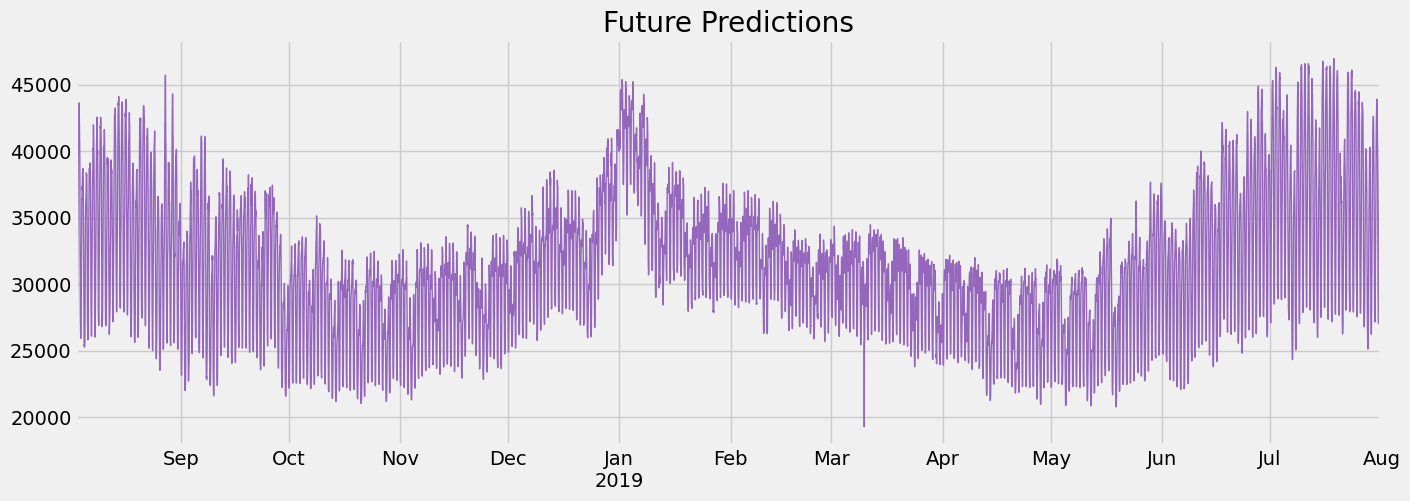

In [212]:
future_w_features['pred'].plot(figsize= (15,5),
                               title = 'Future Predictions',
                               lw = 1, # line_width
                               ms = 1, # marker size
                               color = color_pal[4])

# Saving the model

In [213]:
# svae model

reg.save_model('model.json')

In [214]:
!ls -lh

total 580K
drwx------ 5 root root 4.0K Apr  3 13:55 drive
-rw-r--r-- 1 root root 571K Apr  3 17:08 model.json
drwxr-xr-x 1 root root 4.0K Mar 30 13:53 sample_data


<Axes: title={'center': 'Reloaded Model Future Predicitons'}>

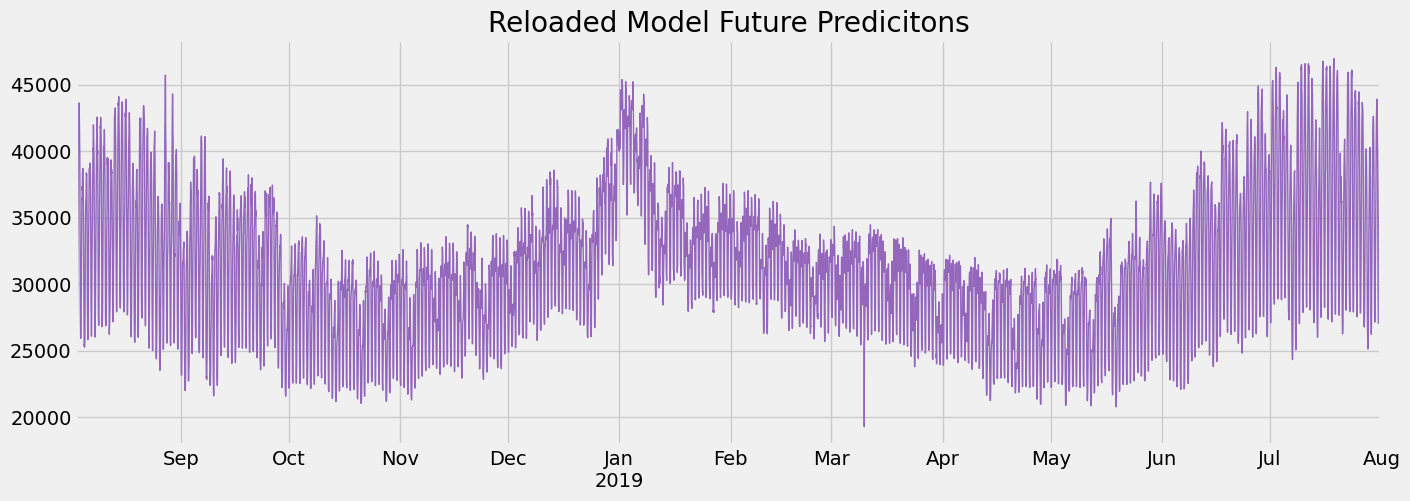

In [217]:
reg_new = XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(15,5),
                                color = color_pal[4],
                                ms = 1, lw = 1,
                                title = 'Reloaded Model Future Predicitons')

In [222]:
#from fbprophet import Prophet

In [223]:
import yfinance as yf